# Instalasi dan Import Library

Langkah ini menginstal library yang dibutuhkan (`stanza` dan `tqdm`) dan mengimpornya untuk digunakan dalam analisis.

In [ ]:
# 0) Install & import
!pip -q install stanza tqdm

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import stanza
import math
import matplotlib.pyplot as plt

### Konfigurasi Awal

Bagian ini menetapkan variabel konfigurasi utama seperti path ke file CSV dataset, nama kolom teks yang akan diproses, dan direktori untuk menyimpan output.

In [ ]:
# --- konfigurasi utama ---
CSV_PATH   = "garudaindonesia_news_cleaned_simple.csv"  # ganti ke path dataset kamu
TEXT_COL   = "konten_nostop"     # <=== pakai kolom sebelum stemming
OUT_DIR    = "/content"
MAX_DOCS   = None

###  Memuat Data

Kode ini membaca data dari file CSV yang ditentukan, memastikan kolom teks yang relevan ada, dan memuat teks ke dalam list untuk diproses lebih lanjut.

In [ ]:
# === 1) Load data ===
df = pd.read_csv(CSV_PATH)
assert TEXT_COL in df.columns, f"Kolom '{TEXT_COL}' tidak ada di CSV."
texts = df[TEXT_COL].astype(str).fillna("").tolist()
if MAX_DOCS is not None:
    texts = texts[:MAX_DOCS]
print(f"Jumlah dokumen: {len(texts)}")

Jumlah dokumen: 469


###  Mengunduh & Inisialisasi Pipeline Stanza (Bahasa Indonesia)

Langkah ini mengunduh model bahasa Indonesia yang diperlukan oleh Stanza dan menginisialisasi pipeline Stanza dengan prosesor untuk tokenisasi, POS tagging, dan lemmatisasi.

In [ ]:
# 2) Download & init pipeline Stanza (Bahasa Indonesia)
stanza.download('id')  # sekali saja; akan skip jika sudah ada
nlp = stanza.Pipeline(
    lang='id',
    processors='tokenize,pos,lemma',   # lemma opsional tapi sering berguna
    use_gpu=True                       # aktifkan GPU di Runtime -> Change runtime type -> GPU
)

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: id (Indonesian) ...
INFO:stanza:File exists: /root/stanza_resources/id/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| lemma     | gsd_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
# 3) Fungsi helper untuk memproses batch teks
def process_batch(batch_texts, start_idx=0):
    doc = nlp("\n\n".join(batch_texts))  # join pakai blank line -> tiap teks jadi "document"
    rows = []
    # Stanza akan menganggap setiap "document" dipisah blank line sebagai paragraf berturut,
    # kita track doc_id manual via counter ketika menemukan blank line boundary
    doc_id = start_idx
    sent_id = 0
    for par in doc.sentences:
        # ketika Stanza ketemu blank line boundary, dia reset sentence stream?
        # cara paling aman: kita hitung jumlah token; ketika sent.text == '' tidak reliable
        # Simpel: batasi per batch = satu "dokumen gabungan", lalu assign doc_id via marker khusus.
        # Karena pendekatan gabung bisa bikin doc_id sulit, alternatif: proses satu per satu.
        # Supaya mudah & jelas, kita pakai cara satu-per-satu untuk akurasi doc_id.

        pass

###  POS Tagging per Dokumen

Bagian ini melakukan POS tagging pada setiap dokumen teks dalam dataset menggunakan pipeline Stanza dan menyimpan hasilnya (token, lemma, UPOS, XPOS) dalam sebuah DataFrame pandas.

In [ ]:
# === 3) POS Tagging per dokumen ===
all_rows = []
for i, text in tqdm(list(enumerate(texts)), total=len(texts), desc="POS tagging"):
    if not text.strip():
        continue
    doc = nlp(text)
    for s_idx, sent in enumerate(doc.sentences):
        for t_idx, token in enumerate(sent.tokens):
            w = token.words[0]
            all_rows.append({
                "doc_id": i,
                "sent_id": s_idx,
                "token_id": t_idx,
                "token": token.text,
                "lemma": w.lemma if hasattr(w, "lemma") else "",
                "upos": w.upos,                # Universal POS (NOUN, VERB, ADJ, ...)
                "xpos": getattr(w, "xpos", "") # spesifik bahasa
            })

pos_df = pd.DataFrame(all_rows)
print(pos_df.head())
print("Total token:", len(pos_df))

POS tagging:   0%|          | 0/469 [00:00<?, ?it/s]

   doc_id  sent_id  token_id      token      lemma   upos xpos
0       0        0         0     garuda     garuda  PROPN  F--
1       0        0         1  indonesia  indonesia  PROPN  NSD
2       0        0         2     rupslb     rupslb  PROPN  X--
3       0        0         3     tengah     tengah   NOUN  NSD
4       0        0         4        isu        isu   NOUN  NSD
Total token: 123907


###  Ringkasan POS Global

Kode ini menghitung frekuensi kemunculan setiap Universal POS (UPOS) tag di seluruh dataset untuk mendapatkan gambaran distribusi POS secara global.

In [ ]:

# === 5) Ringkasan POS global ===
pos_counts = pos_df["upos"].value_counts().reset_index()
pos_counts.columns = ["upos", "count"]
print(pos_counts)

     upos  count
0    NOUN  69822
1    VERB  19486
2   PROPN  10999
3     ADJ   8270
4       X   3604
5     ADV   3320
6     ADP   3277
7     DET   2205
8     NUM   1046
9   SCONJ    570
10   PART    521
11   PRON    354
12    AUX    260
13  CCONJ    172
14  PUNCT      1


### Visualisasi Distribusi POS

Langkah ini membuat visualisasi berupa bar chart horizontal untuk menampilkan distribusi global POS tag berdasarkan hitungan yang diperoleh pada langkah sebelumnya.

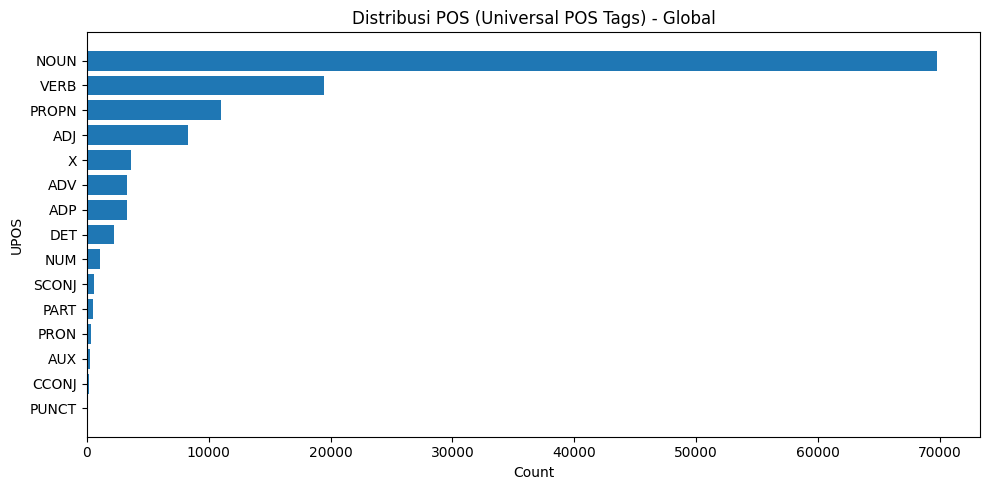

In [ ]:
# === 6) Visualisasi distribusi POS ===
plt.figure(figsize=(10,5))
plt.barh(pos_counts["upos"][::-1], pos_counts["count"][::-1])
plt.xlabel("Count")
plt.ylabel("UPOS")
plt.title("Distribusi POS (Universal POS Tags) - Global")
plt.tight_layout()
plt.show()

### Rasio POS per Dokumen

Bagian ini menghitung rasio kemunculan setiap POS tag dalam setiap dokumen secara terpisah, memberikan insight tentang komposisi POS di tingkat dokumen.

In [ ]:
ratio = (pos_df
         .groupby(["doc_id","upos"]).size()
         .unstack(fill_value=0))
ratio = ratio.div(ratio.sum(axis=1), axis=0)
ratio.head()  # NOUN/VERB/ADJ/ADV per dokumen

upos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
doc_id,,,,,,,,,,,,,,,
0,0.053957,0.021583,0.007194,0.000000,0.003597,0.017986,0.597122,0.010791,0.000000,0.000000,0.107914,0.0,0.014388,0.154676,0.010791
1,0.064220,0.036697,0.000000,0.000000,0.000000,0.000000,0.596330,0.000000,0.000000,0.000000,0.183486,0.0,0.000000,0.110092,0.009174
2,0.045181,0.006024,0.051205,0.006024,0.000000,0.021084,0.560241,0.012048,0.021084,0.000000,0.060241,0.0,0.018072,0.174699,0.024096
3,0.058511,0.005319,0.021277,0.000000,0.002660,0.007979,0.603723,0.015957,0.002660,0.000000,0.069149,0.0,0.000000,0.188830,0.023936
4,0.081967,0.016393,0.052459,0.006557,0.000000,0.013115,0.544262,0.013115,0.016393,0.009836,0.065574,0.0,0.006557,0.157377,0.016393


### Kolokasi ADJ–NOUN (jendela ±2 kata)

Langkah ini mengidentifikasi dan menghitung kemunculan pasangan kata (kolokasi) antara kata sifat (ADJ) dan kata benda (NOUN atau PROPN) dalam jendela ±2 kata di sekitar kata sifat.

In [ ]:
# --- Kolokasi ADJ–NOUN (jendela ±2 kata) ---
from collections import Counter
pairs = Counter()
g = pos_df.groupby("doc_id")
for _, gdoc in g:
    toks = gdoc[["token","upos"]].to_numpy()
    for i,(tok,tag) in enumerate(toks):
        if tag == "ADJ":
            for j in range(max(0,i-2), min(len(toks), i+3)):
                if toks[j][1] in ("NOUN","PROPN"):
                    pairs[(tok.lower(), toks[j][0].lower())] += 1
pairs.most_common(20)

[(('utama', 'direktur'), 263),
 (('utama', 'garuda'), 234),
 (('utama', 'indonesia'), 178),
 (('sama', 'kerja'), 90),
 (('merah', 'pelat'), 89),
 (('baru', 'pesawat'), 82),
 (('internasional', 'bandara'), 81),
 (('nasional', 'maskapai'), 75),
 (('merah', 'maskapai'), 67),
 (('utama', 'pt'), 65),
 (('operasional', 'penerbangan'), 64),
 (('nasional', 'penerbangan'), 62),
 (('depan', 'tahun'), 57),
 (('internasional', 'rute'), 56),
 (('domestik', 'penerbangan'), 55),
 (('besar', 'sebagian'), 52),
 (('panjang', 'jangka'), 51),
 (('sebelumnya', 'tahun'), 51),
 (('nasional', 'indonesia'), 51),
 (('nasional', 'garuda'), 51)]